In [1]:
suppressMessages(library(magrittr))      # provides the %>% operator
suppressMessages(library("genefilter"))
suppressMessages(library(DESeq2))
suppressMessages(library(tximport))
suppressMessages(library("readr"))
suppressMessages(library("tximportData"))
suppressMessages(library(data.table))

suppressMessages(library(matrixStats))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(topGO))

suppressMessages(library(pheatmap))
suppressMessages(library(gplots))
suppressMessages(library(matrixStats))
suppressMessages(library(ggvenn))
suppressMessages(library(edgeR))
suppressMessages(library(pROC))
suppressMessages(library(ggpubr))
suppressMessages(library(eulerr))

options(stringsAsFactors = FALSE)
set.seed(42)

In [2]:
count_matrix_wb = "../files_for_manuscript/count_matrix_wbrna.txt"
count_file_plasma = "../files_for_manuscript/count_matrix_validation.txt"
SAMPLE_ID_VAR = "Cornell_ID"
gene_name_key = "../files_for_manuscript/gencode.biotype.name.key.tsv"
gene.list = read.delim(gene_name_key)
meta = read.delim("../files_for_manuscript/meta_data_updated.txt")
top150 = read.delim("../files_for_manuscript/top150genes.csv")
keep.gene = gene.list[gene.list$gene_name %in% top150$x,1]
signature = gene.list[gene.list$gene_name %in% c("GBP5","DYSF","VAMP5","SMARCD3","FCGR3B","GPI","CREB5","GBP2", "MPO"),1]

In [3]:
meta$`Semiquant.Xpert.result.3`[meta$Semiquant.Xpert.result.3 == "Trace"]= "Low"
meta$`Semiquant.Xpert.result.3`[meta$Semiquant.Xpert.result.3 == "Very low"]= "Low"
meta$`Semiquant.Xpert.result.3`[meta$Microbiologic.reference.standard == "Negative"]= "Negative"

In [4]:
counts_plasma = read.delim(count_file_plasma, row.names=c(1))
counts_wb = read.delim(count_matrix_wb, row.names=c("geneID")) %>% select(-c(row.names))
counts_all = merge(counts_plasma, counts_wb, by="row.names") 
counts_all[is.na(counts_all)]=0
rownames(counts_all)=counts_all$Row.names
counts_wb = counts_all[,grepl("WBRNA", colnames(counts_all))]
counts_plasma = counts_all[,grepl("cfRNA", colnames(counts_all))]

## FIG 4A

In [5]:
plasma_score = counts_plasma[rownames(counts_plasma) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.)%in% signature) %>% data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1))  %>% summarise_all(mean) %>%
t() %>% data.frame() %>% magrittr::set_colnames("score" ) %>% tibble::add_column('sample'=rownames( . )) %>%
merge(. , meta, by.x="sample",by.y="Cornell_ID") %>%
mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) %>%
   group_by(Semiquant.Xpert.result.3, cohort)%>% 
mutate(Microbiologic.reference.standard=factor(Microbiologic.reference.standard, levels=c("Negative","Positive")))


wb_score = counts_wb[rownames(counts_wb) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.)%in% signature) %>% data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1))  %>% summarise_all(mean) %>%
t() %>% data.frame() %>% magrittr::set_colnames("score" ) %>% tibble::add_column('sample'=rownames( . )) %>%
merge(. , meta, by.x="sample",by.y="Cornell_ID") %>%
mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) %>%
   group_by(Semiquant.Xpert.result.3, cohort) %>%
mutate(Microbiologic.reference.standard=factor(Microbiologic.reference.standard, levels=c("Negative","Positive")))


roc_plasma = plasma_score %>% roc(Microbiologic.reference.standard, score, percent=T)
roc_wb = wb_score %>% roc(Microbiologic.reference.standard, score, percent=T)

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


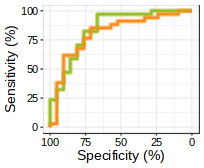

In [6]:

options(repr.plot.height=1.4, repr.plot.width=1.7)
ggroc(list("TB2 (Plasma)"= roc_plasma, "TB2 (WB)" = roc_wb ),aes=c("color"))  +
    theme_bw(base_size=6) + guides(color="none", linetype="none")+
    geom_line(size=1,alpha=0.5)+ scale_color_manual(values=c("#96BE25","#F88C1A")) +
xlab("Specificity (%)") + ylab("Sensitivity (%)") +
theme(axis.text=element_text(size=6, color="black"), axis.title=element_text(size=8, color="black"))


In [7]:
ci.auc(roc_plasma)
ci.auc(roc_wb)

95% CI: 73.05%-95.85% (DeLong)

95% CI: 68.28%-93.34% (DeLong)

## FIG 4B

In [8]:
plasma_semiq = counts_plasma[rownames(counts_plasma) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.)%in% signature) %>% data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1))  %>% summarise_all(mean) %>%
t() %>% data.frame() %>% magrittr::set_colnames("score" ) %>% tibble::add_column('sample'=rownames( . )) %>%
merge(. , meta, by.x="sample",by.y="Cornell_ID") %>%filter(Semiquant.Xpert.result.3 !="") %>% 
mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) %>%
   group_by(Semiquant.Xpert.result.3, cohort)%>% summarise(mean = mean(score, na.rm = TRUE),
                                                             sd = sd(score, na.rm = TRUE),
                                                             n = n()) %>%
    mutate(se = sd / sqrt(n),
           lower.ci = mean - qt(1 - (0.05 / 2), n - 1) * se,
           upper.ci = mean + qt(1 - (0.05 / 2), n - 1) * se)  %>% tibble::add_column('biofluid'="plasma")


wb_semiq = counts_wb[rownames(counts_wb) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.)%in% signature) %>% data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1))  %>% summarise_all(mean) %>%
t() %>% data.frame() %>% magrittr::set_colnames("score" ) %>% tibble::add_column('sample'=rownames( . )) %>%
merge(. , meta, by.x="sample",by.y="Cornell_ID")%>%
filter(Semiquant.Xpert.result.3 !="") %>%
mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) %>%
   group_by(Semiquant.Xpert.result.3, cohort)%>% summarise(mean = mean(score, na.rm = TRUE),
                                                             sd = sd(score, na.rm = TRUE),
                                                             n = n()) %>%
    mutate(se = sd / sqrt(n),
           lower.ci = mean - qt(1 - (0.05 / 2), n - 1) * se,
           upper.ci = mean + qt(1 - (0.05 / 2), n - 1) * se) %>% tibble::add_column('biofluid'="wb")

`summarise()` has grouped output by 'Semiquant.Xpert.result.3'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Semiquant.Xpert.result.3'. You can
override using the `.groups` argument.


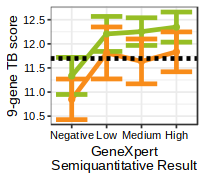

In [9]:
options(repr.plot.height=1.5, repr.plot.width=1.7)

rbind(plasma_semiq, wb_semiq) %>% 
filter(!is.na(Semiquant.Xpert.result.3)) %>%
    ggplot(aes(x=Semiquant.Xpert.result.3, y=mean, color=biofluid, group=biofluid)) + 
    geom_line(size=1) + geom_errorbar(size=1, aes(ymin=lower.ci, ymax=upper.ci)) + 
 geom_point(size=1) + theme_bw(base_size=8) +
    theme( legend.text=element_text(color="black", size=8), legend.position="none", legend.title=element_blank(), 
          legend.key.size = unit(0.1, 'mm'),
         axis.text=element_text(color="black")) +
    xlab("GeneXpert\nSemiquantitative Result") + ylab("9-gene TB score")  +
    scale_color_manual(values=c("#96BE25", "#F88C1A")) +
geom_hline(yintercept=11.6975977111331, linetype="dashed", size=1)

## FIG 4C

In [10]:
cto_discovery =read.delim("../files_for_manuscript/cto.txt")
cto_validation = read.delim("../files_for_manuscript/cto_validation.txt")
cto_wb = read.delim("../files_for_manuscript/cto_wb.txt")

In [11]:
decon = rbind(cto_discovery, cto_validation, cto_wb)
decon_melt = unique(melt(decon, id.vars="sample_id") %>% rename(celltype = variable, fraction = value)  %>%
    merge(. , meta, by.x="sample_id", by.y="Cornell_ID"))

Warning message in melt(decon, id.vars = "sample_id"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(decon). In the next version, this warning will become an error.”


In [12]:
results <- decon_melt
sum <- results %>% group_by(celltype) %>% summarize(mean=mean(fraction))
sum <- sum[order(sum$mean,decreasing=TRUE),]

genes = sum$celltype

suppressMesssages(library(qualpalr))

num_cells = length(genes)
pal = sample(rev(qualpal(num_cells, colorspace=list(h=c(0,360), s=c(0.3,1), l=c(0.2,0.8)))$hex))
pal = c('#1362AB','#740C33','#2C8DAF','#FB927F','#5CFBF4','#0234C1','#86C35E','#B414A8','#F191B8','#949D0A','#700862','#F5DB9E','#209510','#DBB008','#5C6BFA','#B27DF2','#D6F306','#5EFE36','#A9DAC9','#B2040D','#203760','#4D5D0D','#4A1E80','#F63DFA','#F8169B','#175738','#0C8559','#A1506B','#861FF1','#2BBBB3','#5E210C','#36B976','#CAA376','#D75E16','#73480D','#39F9AD','#85D2F8','#65A2FC','#FC092B','#94A514','#AEBBE6')

colors = pal
labels = genes

val_vector = colors
names(val_vector) = labels

In [13]:
solid_labels = c('Fibroblast mesenchymal stem cell',
                'Endothelial.cell',
    'Respiratory.ciliated.cell',
                 'Ionocyte.luminal.epithelial.cell.of.mammary.gland','Kidney.epithelial.cell',
                 'Cell.of.skeletal.muscle','Intestinal.tuft.cell',
    'Intestinal.enterocyte',
                 'Prostate.epithelia',
    'Salivary.bronchial.secretory.cell',
    'Intestinal.secretory.cell',
                 'Secretory.cell','Respiratory.secretory.cell','Basal.prostate.cell','Basal.cell',
                 'Salivary.gland.cell','Pancreatic.Stellate.cell','Type.II.Pneumocyte',
                 'Intrahepatic.cholangiocyte','Gland.cell','Mesothelial cell',
    'Schwann.cell',
                 'Pancreatic.alpha.beta.cell','Tendon cell',
    'Pericyte.cell')
solid_colors = colors[1:25]

val_vector_solid = solid_colors

names(val_vector_solid) = solid_labels

val_vector_solid = val_vector_solid[order(match(names(val_vector_solid),genes))]

In [14]:
newtot =results  %>% filter(celltype !="Platelet") %>% group_by(sample_id) %>% summarise(newtot = sum(fraction))
newresults = results %>% filter(celltype != "Platelet")
newresults = merge(newtot, newresults, by="sample_id")
newresults$newfraction = (newresults$fraction)*(1/newresults$newtot)
newresults$cohort[grepl("WBRNA", newresults$sample_id)]="WBRNA"
res_melt_solid = newresults[which(newresults$celltype %in% names(val_vector_solid)),]
head(newresults)

,sample_id,newtot,celltype,fraction,Country,cohort,HIV.status,Microbiologic.reference.standard,Semiquant.Xpert.result.3,Biofluid,expGroup,newfraction
,<chr>,<dbl>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,GHL1_combined,0.9467102,Type.II.Pneumocyte,2.079005e-04,Uganda,END TB,Negative,Negative,Negative,plasma,Negative,2.196031e-04
2,GHL1_combined,0.9467102,Mature.conventional.dendritic.cell,1.328174e-02,Uganda,END TB,Negative,Negative,Negative,plasma,Negative,1.402936e-02
3,GHL1_combined,0.9467102,NK.Cell,1.100710e-01,Uganda,END TB,Negative,Negative,Negative,plasma,Negative,1.162668e-01
4,GHL1_combined,0.9467102,Respiratory.ciliated.cell,6.312312e-04,Uganda,END TB,Negative,Negative,Negative,plasma,Negative,6.667629e-04
5,GHL1_combined,0.9467102,Salivary.bronchial.secretory.cell,2.958379e-05,Uganda,END TB,Negative,Negative,Negative,plasma,Negative,3.124904e-05
6,GHL1_combined,0.9467102,Myeloid.progenitor,1.736078e-01,Uganda,END TB,Negative,Negative,Negative,plasma,Negative,1.833801e-01


In [15]:
my_comparisons <- list( c("END TB", "WBRNA"), c("GHL", "WBRNA"), c("TB2", "WBRNA") )

`summarise()` has grouped output by 'sample_id'. You can override using the
`.groups` argument.
Warning message:
“Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”


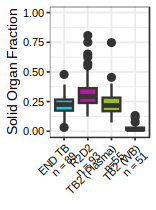

In [16]:
options(repr.plot.height=1.75, repr.plot.width=1.3)
res_melt_solid %>% 
    mutate(celltype = factor(celltype,levels=genes)) %>% group_by(sample_id, cohort) %>% summarise(val=sum(newfraction)) %>%
    ggplot(aes(x=cohort,y=val, fill=cohort)) + geom_boxplot() + theme_bw(base_size=8) + 
stat_compare_means(method="wilcox.test", comparisons=my_comparisons) +
scale_x_discrete(labels=c("END TB\nn = 89", "R2D2\nn = 93","TB2 (Plasma)\nn=55", "TB2 (WB)\nn = 51")) + 
theme(axis.title.x=element_blank(),
      axis.text.x=element_text(color="black", angle=45, hjust=1, vjust=1, size=6),
     axis.text.y=element_text(color="black", size=6),
     axis.title.y=element_text(color="black", size=8),
     legend.position="none") + 
ylab("Solid Organ Fraction") +ylim(0,1) +
scale_fill_manual(values=c("#00D2DE", "#B5179E", "#96BE25", "#F88C1A"))

## FIG 4D

In [17]:
SIG_THRESH = 0.01
FC_THRESH =0.5


In [18]:
## DESEQ - WBRNA
meta_wb = meta[meta$Biofluid=="wb",]
meta_wb = meta_wb[!is.na(meta_wb$Microbiologic.reference.standard),]
meta_wb = meta_wb[meta_wb$Microbiologic.reference.standard!="",]
rownames(meta_wb)=meta_wb$Cornell_ID

counts_wb = read.delim(count_matrix_wb, row.names=c("geneID")) %>% select(-c(row.names))
counts_wb = counts_wb[,colnames(counts_wb) %in% meta_wb$Cornell_ID]

GROUPS = c("Positive","Negative")
meta_wb$expGroup = meta_wb$Microbiologic.reference.standard
meta_wb$expGroup=factor(meta_wb$expGroup, levels=GROUPS)

gene.list <- read.delim(gene_name_key,col.names = c("type,","ENSMBL","gene_symbol"))
gene.ids <- gsub("\\..*","",rownames(counts_wb))

exclude.idx <- gene.ids %in% gene.list[,1]
counts_wb = counts_wb[!exclude.idx,]   
counts_wb = counts_wb[,meta_wb$Cornell_ID]

##------------------------------------
# Contstruct DESeq Data Set
dds_wb <- DESeqDataSetFromMatrix(round(counts_wb),
                                colData = meta_wb,
                                design = ~ expGroup  +  0)


##------------------------------------
# Add Gene metadata
annotation = fread(file=gene_name_key)
annotation <- annotation[match(rownames(dds_wb), annotation$gene_id),]
all(rownames(dds_wb) == annotation$ftcount_id)
mcols(dds_wb) <- cbind(mcols(dds_wb), annotation)


##------------------------------------
# Re-factor
dds_wb$expGroup <- factor(dds_wb$expGroup, levels = GROUPS)

##------------------------------------
# DAA
dds_wb <- DESeq(dds_wb)

res_wb <- results(dds_wb,alpha=0.01, contrast = c("expGroup","Positive", "Negative"))

res_wb$gene_name <- mcols(dds_wb)$gene_name
res_wb$gene_type <- mcols(dds_wb)$gene_type

sig_genes_wb <- data.frame(res_wb) %>% filter(padj < SIG_THRESH & abs(log2FoldChange) > FC_THRESH) %>% rownames()

converting counts to integer mode



[1] TRUE

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 407 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [19]:
sig_genes_plasma = read.table("../files_for_manuscript/DESEq2_output_w_validation.tsv", header=T)
sig_genes_wb = gene.list[gene.list$`type.` %in% sig_genes_wb,]

In [20]:
int = dim(intersect(sig_genes_plasma,sig_genes_wb))[1]
u_wb = dim(sig_genes_wb)[1]-int
u_pl = dim(sig_genes_plasma)[1]-int

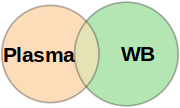

In [21]:
options(repr.plot.height=0.9, repr.plot.width=1.5)

VennDiag = euler(c("Plasma"=u_pl, "WB"=u_wb, "Plasma&WB"=int))
plot(VennDiag, counts=TRUE, fill=c("#F88C1A","#00AC00"), alpha=0.3)

In [22]:
intersect(sig_genes_plasma, sig_genes_wb) %>% filter(ENSMBL %in% gene.list[gene.list$`type` %in% signature,2])

type.,ENSMBL,gene_symbol
<chr>,<chr>,<chr>
ENSG00000162645.13,GBP2,protein_coding
ENSG00000154451.14,GBP5,protein_coding
ENSG00000162747.12,FCGR3B,protein_coding
ENSG00000135636.15,DYSF,protein_coding
ENSG00000146592.17,CREB5,protein_coding


## FIG 4E

In [23]:
counts_wb = read.delim(count_matrix_wb, row.names=c("geneID")) %>% select(-c(row.names))
counts_plasma = read.delim(count_file_plasma, row.names=c(1))

In [24]:
GeomSplitViolin <- ggproto("GeomSplitViolin", GeomViolin, 
                           draw_group = function(self, data, ..., draw_quantiles = NULL) {
                               data <- transform(data, xminv = x - violinwidth * (x - xmin), xmaxv = x + violinwidth * (xmax - x))
                               grp <- data[1, "group"]
                               newdata <- plyr::arrange(transform(data, x = if (grp %% 2 == 1) xminv else xmaxv), if (grp %% 2 == 1) y else -y)
                               newdata <- rbind(newdata[1, ], newdata, newdata[nrow(newdata), ], newdata[1, ])
                               newdata[c(1, nrow(newdata) - 1, nrow(newdata)), "x"] <- round(newdata[1, "x"])
                               
                               if (length(draw_quantiles) > 0 & !scales::zero_range(range(data$y))) {
                                   stopifnot(all(draw_quantiles >= 0), all(draw_quantiles <=
                                                                               1))
                                   quantiles <- ggplot2:::create_quantile_segment_frame(data, draw_quantiles)
                                   aesthetics <- data[rep(1, nrow(quantiles)), setdiff(names(data), c("x", "y")), drop = FALSE]
                                   aesthetics$alpha <- rep(1, nrow(quantiles))
                                   both <- cbind(quantiles, aesthetics)
                                   quantile_grob <- GeomPath$draw_panel(both, ...)
                                   ggplot2:::ggname("geom_split_violin", grid::grobTree(GeomPolygon$draw_panel(newdata, ...), quantile_grob))
                               }
                               else {
                                   ggplot2:::ggname("geom_split_violin", GeomPolygon$draw_panel(newdata, ...))
                               }
                           })
geom_split_violin <- function(mapping = NULL, data = NULL, stat = "ydensity", position = "identity", ..., 
                              draw_quantiles = NULL, trim = TRUE, scale = "area", na.rm = FALSE, 
                              show.legend = NA, inherit.aes = TRUE) {
    layer(data = data, mapping = mapping, stat = stat, geom = GeomSplitViolin, 
          position = position, show.legend = show.legend, inherit.aes = inherit.aes, 
          params = list(trim = trim, scale = scale, draw_quantiles = draw_quantiles, na.rm = na.rm, ...))
}

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


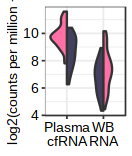

In [25]:
 options(repr.plot.height=1.3, repr.plot.width=1.1)

rbind( counts_wb[rownames(counts_wb) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.) %in% gene.list[gene.list$ENSMBL %in% c("MARCO"),1]) %>% 
data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1)) %>% t() %>% data.frame() %>% tibble::add_column("sample"=rownames(.)) %>%
reshape2::melt(. ,id.var="sample") %>% merge(.,meta, by.x="sample", by.y="Cornell_ID") ,
counts_plasma[rownames(counts_plasma) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.) %in% gene.list[gene.list$ENSMBL %in% c("MARCO"),1]) %>% 
data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1)) %>% t() %>% data.frame() %>% tibble::add_column("sample"=rownames(.)) %>%
reshape2::melt(. ,id.var="sample") %>% merge(.,meta, by.x="sample", by.y="Cornell_ID") )%>% 
filter(value!=0)%>%data.frame() %>%
    ggplot(aes(x=Biofluid, y=value, fill=Microbiologic.reference.standard))+ geom_split_violin()+
    scale_fill_manual(values=c("#433F60", "#FF70A6")) + theme_bw(base_size=8)+
    ylab("log2(counts per million + 1)")  +  scale_x_discrete(labels=c("Plasma\ncfRNA", "WB\nRNA"))+
theme(legend.position="none",
     axis.title.x=element_blank(),
     axis.title=element_text(size=8, color="black"),
     axis.text=element_text(color="black", size=8)) 

In [26]:
rbind( counts_wb[rownames(counts_wb) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.) %in% gene.list[gene.list$ENSMBL %in% c("MARCO"),1]) %>% 
data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1)) %>% t() %>% data.frame() %>% tibble::add_column("sample"=rownames(.)) %>%
reshape2::melt(. ,id.var="sample") %>% merge(.,meta, by.x="sample", by.y="Cornell_ID") ,
counts_plasma[rownames(counts_plasma) %in% keep.gene,] %>% edgeR::cpm() %>% data.frame() %>%
filter(rownames(.) %in% gene.list[gene.list$ENSMBL %in% c("MARCO"),1]) %>% 
data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1)) %>% t() %>% data.frame() %>% tibble::add_column("sample"=rownames(.)) %>%
reshape2::melt(. ,id.var="sample") %>% merge(.,meta, by.x="sample", by.y="Cornell_ID") )%>% 
filter(value!=0)%>%data.frame()  %>%
compare_means(data = ., value~Microbiologic.reference.standard, group.by="Biofluid")

Biofluid,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
wb,value,Negative,Positive,0.189959664,0.7300,0.1900,ns,Wilcoxon
wb,value,Negative,,0.315789474,0.7300,0.3158,ns,Wilcoxon
wb,value,Positive,,0.137931034,0.6900,0.1379,ns,Wilcoxon
plasma,value,Negative,Positive,0.001454066,0.0087,0.0015,**,Wilcoxon
plasma,value,Negative,,1.000000000,1.0000,1.0000,ns,Wilcoxon
plasma,value,Positive,,0.181818182,0.7300,0.1818,ns,Wilcoxon


In [29]:
library(rmarkdown)
convert_ipynb("Fig4_code.ipynb", output = xfun::with_ext("Fig4_code", "Rmd"))

Warning message:
“Detected the following probable line magics. They do not work in R Markdown.

  colors = pal”
